# 1. Set up the notebook

Do imports.

In [78]:
import numpy as np
import sympy as sym
from scipy import linalg
import json
import matplotlib.pyplot as plt
from ae483tools import *

Check mocap coverage from `lab07_square01.json`.

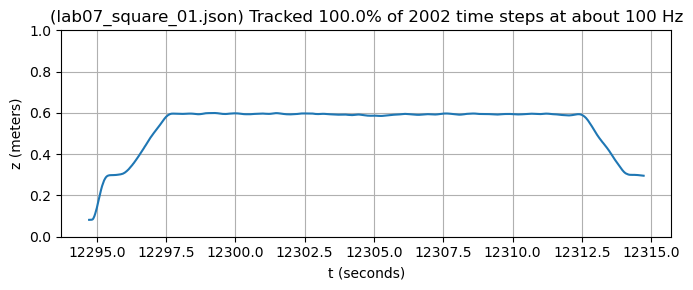

In [79]:
check_mocap_coverage('lab07_square_01.json')

# 2. Derive models

## 2.1 Define symbolic variables

Define states.

In [80]:
# components of position (meters)
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z')

# yaw, pitch, and roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')

Define inputs.

In [81]:
# gyroscope measurements - components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# z-axis accelerometer measurement - specific force (meters / second^2)
a_z = sym.symbols('a_z')

Define outputs.

In [82]:
n_x, n_y, r = sym.symbols('n_x, n_y, r')

Define parameters.

In [83]:
g, k_flow = sym.symbols('g, k_flow')

Create the linear velocity vector $v^B_{W, B}$ and the angular velocity vector $w^B_{W, B}$, both written in the coordinates of the body frame.

In [84]:
v_inB_ofWB = sym.Matrix([v_x, v_y, v_z])
w_inB_ofWB = sym.Matrix([w_x, w_y, w_z])

## 2.2 Define kinematics of orientation

### 2.2.1 Rotation matrix in terms of yaw, pitch, roll angles

Define individual rotation matrices.

In [85]:
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0],
                 [sym.sin(psi), sym.cos(psi), 0],
                 [0, 0, 1]])

Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)],
                 [0, 1, 0],
                 [-sym.sin(theta), 0, sym.cos(theta)]])

Rx = sym.Matrix([[1, 0, 0],
                 [0, sym.cos(phi), -sym.sin(phi)],
                 [0, sym.sin(phi), sym.cos(phi)]])

Apply sequential transformation to compute the rotation matrix that describes the orientation of the drone (i.e., of frame $B$ in the coordinates of frame $W$).

In [86]:
R_inW_ofB = Rz * Ry * Rx

### 2.2.2 Map from angular velocity to angular rates

Recall that

$$\begin{bmatrix} \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \end{bmatrix} = N w_{W, B}^{B}$$

for some matrix $N$. Here is how to compute that matrix for a ZYX (yaw, pitch, roll) Euler angle sequence.  First, we compute its inverse:

In [87]:
Ninv = sym.Matrix.hstack((Ry * Rx).T * sym.Matrix([[0], [0], [1]]),
                              (Rx).T * sym.Matrix([[0], [1], [0]]),
                                       sym.Matrix([[1], [0], [0]]))

Then, we compute $N$ by taking the inverse of $N^{-1}$:

In [88]:
N = sym.simplify(Ninv.inv())

## 2.3 Derive equations of motion

Define $a^\text{SF}$, i.e., "acceleration without the gravity term."

In [89]:
aSF = sym.Matrix([
    w_inB_ofWB.cross(v_inB_ofWB)[0],
    w_inB_ofWB.cross(v_inB_ofWB)[1],
    a_z,
])

Create equations of motion.

In [90]:
f = sym.Matrix.vstack(
    R_inW_ofB * v_inB_ofWB,
    N * w_inB_ofWB,
    R_inW_ofB.T * sym.Matrix([0, 0, - g]) + aSF,
)

Show equations of motion, which have the form

$$\dot{s} = f(s, i, p)$$

where

$$
s = \begin{bmatrix} o_x \\ o_y \\ o_z \\ \psi \\ \theta \\ \phi \\ v_x \\ v_y \\ v_z \end{bmatrix}
\qquad\qquad
i = \begin{bmatrix} w_x \\ w_y \\ w_z \\ a_z \end{bmatrix}
\qquad\qquad
p = \begin{bmatrix} g \\ k_\text{flow} \end{bmatrix}.
$$

In [91]:
f

Matrix([
[ v_x*cos(psi)*cos(theta) + v_y*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + v_z*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))],
[v_x*sin(psi)*cos(theta) + v_y*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) + v_z*(-sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi))],
[                                                                       -v_x*sin(theta) + v_y*sin(phi)*cos(theta) + v_z*cos(phi)*cos(theta)],
[                                                                                         w_y*sin(phi)/cos(theta) + w_z*cos(phi)/cos(theta)],
[                                                                                                               w_y*cos(phi) - w_z*sin(phi)],
[                                                                                   w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[                                                                                                          g*sin(theta) - v_y*w_z + v_z*w_y

## 2.4 Derive measurement equations

Create measurement equations.

In [92]:
h = sym.Matrix([
    k_flow * (v_x - p_z * w_y) / p_z,        # <-- x flow (n_x)
    k_flow * (v_y + p_z * w_x) / p_z,        # <-- y flow (n_y)
    p_z / (sym.cos(phi) * sym.cos(theta)),   # <-- z range (r)
])

Show measurement equations, which have the form

$$o = h(s, i, p)$$

where

$$
o = \begin{bmatrix} n_x \\ n_y \\ r \end{bmatrix}
\qquad\qquad
s = \begin{bmatrix} o_x \\ o_y \\ o_z \\ \psi \\ \theta \\ \phi \\ v_x \\ v_y \\ v_z \end{bmatrix}
\qquad\qquad
i = \begin{bmatrix} w_x \\ w_y \\ w_z \\ a_z \end{bmatrix}
\qquad\qquad
p = \begin{bmatrix} g \\ k_\text{flow} \end{bmatrix}.
$$

In [93]:
h

Matrix([
[k_flow*(-p_z*w_y + v_x)/p_z],
[ k_flow*(p_z*w_x + v_y)/p_z],
[  p_z/(cos(phi)*cos(theta))]])

# 3. Derive state-space model

## 3.1 Choose equilibrium point

An equilibrium point of the nonlinear system is a choice of states $s_\text{eq}$ and inputs $i_\text{eq}$ — along with constant parameters $p_\text{eq}$ — for which

$$0 = f(s_\text{eq}, i_\text{eq}, p_\text{eq}).$$

Create a symbolic variable to describe the equilibrium value of $p_z$.

In [94]:
p_z_eq = sym.symbols('p_z_eq')

Create a list of states, inputs, outputs, and parameters as symbolic variables.

In [95]:
s = [p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z]
i = [w_x, w_y, w_z, a_z]
o = [n_x, n_y, r]
p = [g, k_flow]

Create a list of state and input values at equilibrium in the **same order** as before.

In [96]:
s_eq = [0, 0, p_z_eq, 0, 0, 0, 0, 0, 0]
i_eq = [0, 0, 0, g]

Make sure all equilibrium values are symbolic.

In [97]:
s_eq = [sym.nsimplify(a) for a in s_eq]
i_eq = [sym.nsimplify(a) for a in i_eq]

Evaluate the equations of motion at the equilibrium point - if it actually *is* an equilibrium point, then the result should be a matrix of zeros:

In [98]:
f.subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))

Matrix([
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0]])

## 3.2 Find $A$, $B$, $C$, and $D$

Recall that:

$$
A = \frac{\partial f}{\partial s}\biggr\vert_{(s, i, p) = (s_\text{eq}, i_\text{eq}, p_\text{eq})}
\qquad\quad
B = \frac{\partial f}{\partial i}\biggr\vert_{(s, i, p) = (s_\text{eq}, i_\text{eq}, p_\text{eq})}
\qquad\quad
C = \frac{\partial h}{\partial s}\biggr\vert_{(s, i, p) = (s_\text{eq}, i_\text{eq}, p_\text{eq})}
\qquad\quad
D = \frac{\partial h}{\partial i}\biggr\vert_{(s, i, p) = (s_\text{eq}, i_\text{eq}, p_\text{eq})}.
$$

Compute each Jacobian and plug in the equilibrium values as follows.

In [99]:
A = f.jacobian(s).subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))
B = f.jacobian(i).subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))
C = h.jacobian(s).subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))
D = h.jacobian(i).subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))

Show $A$:

In [100]:
A

Matrix([
[0, 0, 0, 0, 0,  0, 1, 0, 0],
[0, 0, 0, 0, 0,  0, 0, 1, 0],
[0, 0, 0, 0, 0,  0, 0, 0, 1],
[0, 0, 0, 0, 0,  0, 0, 0, 0],
[0, 0, 0, 0, 0,  0, 0, 0, 0],
[0, 0, 0, 0, 0,  0, 0, 0, 0],
[0, 0, 0, 0, g,  0, 0, 0, 0],
[0, 0, 0, 0, 0, -g, 0, 0, 0],
[0, 0, 0, 0, 0,  0, 0, 0, 0]])

Show $B$:

In [101]:
B

Matrix([
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 1, 0],
[0, 1, 0, 0],
[1, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 1]])

Show $C$:

In [102]:
C

Matrix([
[0, 0, 0, 0, 0, 0, k_flow/p_z_eq,             0, 0],
[0, 0, 0, 0, 0, 0,             0, k_flow/p_z_eq, 0],
[0, 0, 1, 0, 0, 0,             0,             0, 0]])

Show $D$ (note that it is *not* zero in this case):

In [103]:
D

Matrix([
[     0, -k_flow, 0, 0],
[k_flow,       0, 0, 0],
[     0,       0, 0, 0]])

## 3.3 Write linearized models

Define the state, input, and output of the state-space system (i.e., the linearized model of the equations of motion and of the measurement equations).

In [104]:
x = sym.Matrix(s) - sym.Matrix(s_eq)
u = sym.Matrix(i) - sym.Matrix(i_eq)
y = sym.Matrix(o) - h.subs(tuple(zip(s, s_eq))).subs(tuple(zip(i, i_eq)))

Show the linearized equations of motion $Ax+Bu$.

In [105]:
A * x + B * u

Matrix([
[    v_x],
[    v_y],
[    v_z],
[    w_z],
[    w_y],
[    w_x],
[g*theta],
[ -g*phi],
[a_z - g]])

Show the linearized measurement equations $Cx+Du$.

In [106]:
C * x + D * u

Matrix([
[-k_flow*w_y + k_flow*v_x/p_z_eq],
[ k_flow*w_x + k_flow*v_y/p_z_eq],
[                   p_z - p_z_eq]])

Show the output (which our model tells us should be $Cx+Du$).

In [107]:
y

Matrix([
[        n_x],
[        n_y],
[-p_z_eq + r]])

# 4. Study error in linearized models

## 4.1 Load and parse flight data

**Replace this cell** with a description of the flight trajectory, flight conditions, flight settings (e.g., what was the value of `use_controller`), etc., that produced the data `lab07_square01.json` you are using in this section.

Load flight data.

In [108]:
# Load flight data
raw_data_drone, raw_data_mocap = load_hardware_data('lab07_square_01.json')

# Resample drone data
data_drone = resample_data_drone(
    raw_data_drone,
    t_min_offset=0., # <-- FIXME
    t_max_offset=0., # <-- FIXME
)

# Sync and resample mocap data
data_mocap = sync_data_mocap(raw_data_mocap, data_drone['time'], data_drone['ae483log.p_z'])

# Only look at data from when the drone was actually flying
only_in_flight(data_drone, data_mocap=data_mocap)

Parse flight data.

In [109]:
# Drone data
# time
t = data_drone['time']
# states
p_x = data_drone['ae483log.p_x']
p_y = data_drone['ae483log.p_y']
p_z = data_drone['ae483log.p_z']
psi = data_drone['ae483log.psi']
theta = data_drone['ae483log.theta']
phi = data_drone['ae483log.phi']
v_x = data_drone['ae483log.v_x']
v_y = data_drone['ae483log.v_y']
v_z = data_drone['ae483log.v_z']
# inputs
w_x = data_drone['ae483log.w_x']
w_y = data_drone['ae483log.w_y']
w_z = data_drone['ae483log.w_z']
a_z = data_drone['ae483log.a_z']
# outputs
n_x = data_drone['ae483log.n_x']
n_y = data_drone['ae483log.n_y']
r = data_drone['ae483log.r']

# Mocap data
p_x_mocap = data_mocap['x']
p_y_mocap = data_mocap['y']
p_z_mocap = data_mocap['z']
psi_mocap = data_mocap['yaw']
theta_mocap = data_mocap['pitch']
phi_mocap = data_mocap['roll']

Find time step (should be 0.01).

In [110]:
dt = t[1] - t[0]
print(f'dt = {dt:.4f}')
assert(np.isclose(dt, 0.01))

dt = 0.0100


Define numerical values of each parameter. **Modify the text in this cell** to justify your choice of $p_{z,\text{eq}}$.

In [111]:
# Acceleration of gravity
g = 9.81

# Optical flow constant (do not modify)
k_flow = 0.01 * 30.0 / np.deg2rad(4.2)

# Equilibrium value of p_z
p_z_eq = 0.0    # <-- FIXME

## 4.2 Error in linearized equations of motion

### 4.2.1 Error in linear model of $\dot{p}_x$

Approximate $\dot{p}_x$ by finite difference and call this "ground truth."

In [112]:
p_x_dot_true = (p_x[1:] - p_x[:-1]) / dt

Remember that, because of the way it is computed, the length of the finite difference approximation `p_x_dot_true` is one less than the length of `p_x` (and of `t`):

In [113]:
print(f'len(p_x_dot_true) = {len(p_x_dot_true)}')
print(f'         len(p_x) = {len(p_x)}')
print(f'           len(t) = {len(t)}')

len(p_x_dot_true) = 2003
         len(p_x) = 2004
           len(t) = 2004


Predict $\dot{p}_x$ with linearized equations of motion.

In particular, note that the first element of $\dot{x}$ is

$$ \dfrac{d}{dt}\left( p_x - p_{x,\text{eq}} \right) = \dot{p}_x, $$

and that the first element of $Ax+Bu$ is $v_x$. So, our state-space model tells us that $\dot{p}_x \approx v_x$.

In [114]:
p_x_dot_predicted = v_x

Compare the true value and the predicted values of $\dot{p}_x$ in a plot.

Text(0.5, 0, 'time (s)')

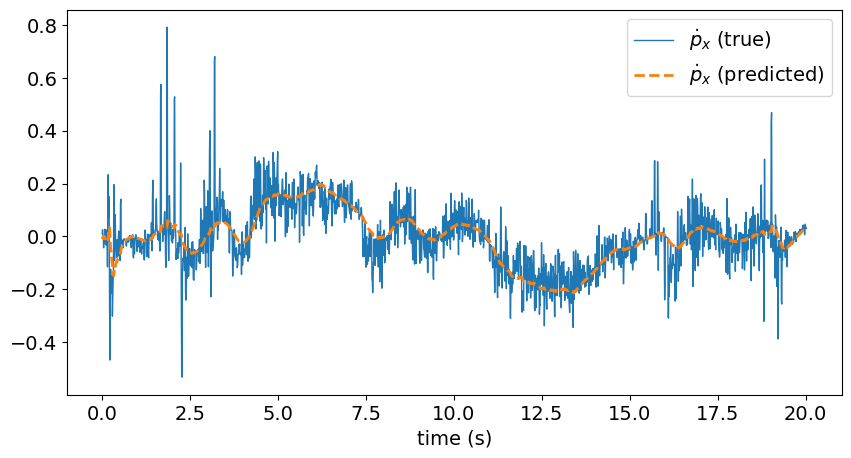

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(t[:-1], p_x_dot_true, label=r'$\dot{p}_x$ (true)', linewidth=1)
ax.plot(t, p_x_dot_predicted, '--', label=r'$\dot{p}_x$ (predicted)', linewidth=2)
ax.legend(fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xlabel('time (s)', fontsize=14)

Compute the error in the linear model, i.e., the difference between the predicted and true values of $\dot{p}_x$.

In [116]:
p_x_dot_err = p_x_dot_predicted[:-1] - p_x_dot_true

Plot a histogram of the error, showing mean and standard deviation.

Text(0.5, 1.0, 'Error in prediction of $\\dot{p}_x$\n(mean = -0.000, std =  0.084)')

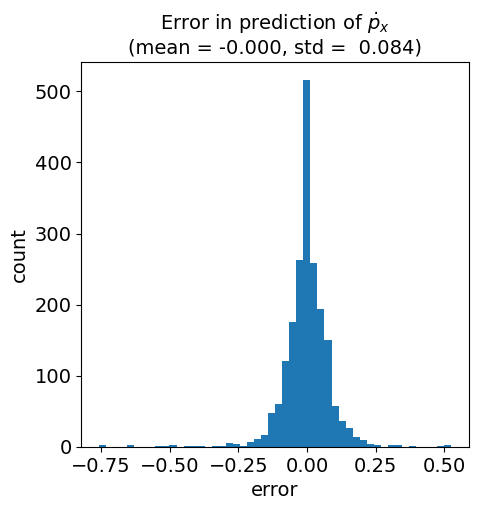

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(p_x_dot_err, 50)
ax.set_xlabel('error', fontsize=14)
ax.set_ylabel('count', fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title(
    r'Error in prediction of $\dot{p}_x$' +
    f'\n(mean = {np.mean(p_x_dot_err):6.3f}, std = {np.std(p_x_dot_err):6.3f})',
    fontsize=14,
)

### 4.2.2 Error in linear model of $\dot{p}_y$

### 4.2.3 Error in linear model of $\dot{p}_z$

### 4.2.4 Error in linear model of $\dot{\psi}$

### 4.2.5 Error in linear model of $\dot{\theta}$

### 4.2.6 Error in linear model of $\dot{\phi}$

### 4.2.7 Error in linear model of $\dot{v}_x$

### 4.2.8 Error in linear model of $\dot{v}_y$

### 4.2.9 Error in linear model of $\dot{v}_z$

## 4.3 Error in linearized measurement equations

### 4.3.1 Error in linear model of $n_x$

Predict $n_x$ with the linearized measurement equations.

In particular, note that the first element of $y$ is $n_x$, and that the first element of $Cx+Du$ is

$$k_\text{flow} \left( \dfrac{v_x}{p_\text{z, eq}} - w_y \right),$$

so our linear model tells us that

$$n_x \approx k_\text{flow} \left( \dfrac{v_x}{p_\text{z, eq}} - w_y \right).$$

In [118]:
n_x_predicted = k_flow * ((v_x / p_z_eq) - w_y)

/tmp/ipykernel_33169/1181640691.py:1: RuntimeWarning: divide by zero encountered in divide
  n_x_predicted = k_flow * ((v_x / p_z_eq) - w_y)


Compare the true value and the predicted values of $n_x$ in a plot.

Text(0.5, 0, 'time (s)')

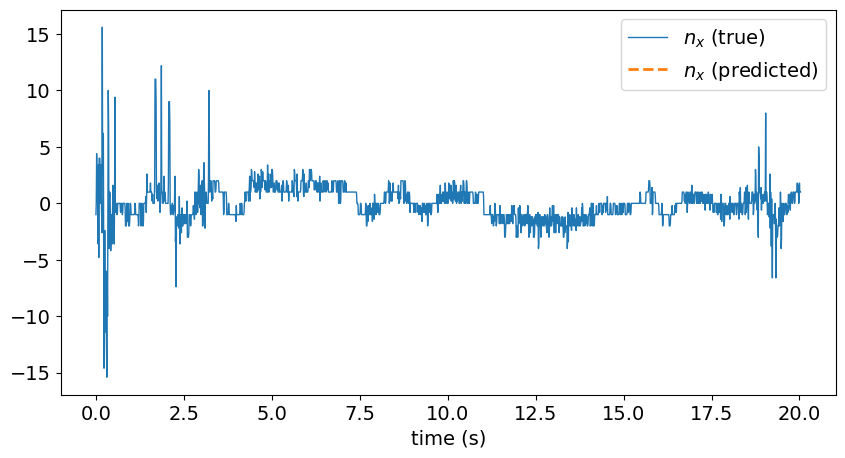

In [119]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(t, n_x, label=r'$n_x$ (true)', linewidth=1)
ax.plot(t, n_x_predicted, '--', label=r'$n_x$ (predicted)', linewidth=2)
ax.legend(fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xlabel('time (s)', fontsize=14)

Compute the error in the linear model, i.e., the difference between the predicted and true values of $n_x$.

In [120]:
n_x_err = n_x_predicted - n_x

Plot a histogram of the error, showing mean and standard deviation.

ValueError: supplied range of [-inf, inf] is not finite

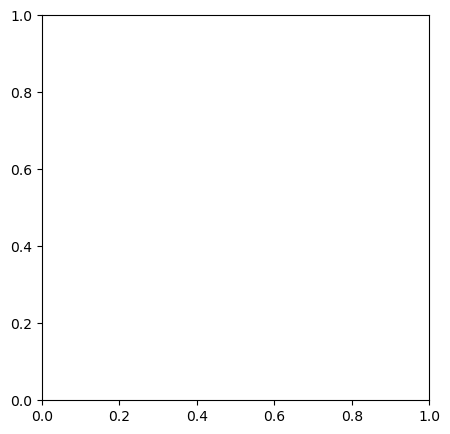

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(n_x_err, 50)
ax.set_xlabel('error', fontsize=14)
ax.set_ylabel('count', fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title(
    r'Error in prediction of $n_x$' +
    f'\n(mean = {np.mean(n_x_err):6.3f}, std = {np.std(n_x_err):6.3f})',
    fontsize=14,
)

### 4.3.2 Error in linear model of $n_y$

### 4.3.3 Error in linear model of $r$

## 4.4 Summary

The following table reports the mean and standard deviation of error in the linearized equations of motion:

|  | $\dot{p}_x$ | $\dot{p}_y$ | $\dot{p}_z$ | $\dot{\psi}$ | $\dot{\theta}$ | $\dot{\phi}$ | $\dot{v}_x$ | $\dot{v}_y$ | $\dot{v}_z$ |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
| mean | 0.123 | 0.456 | 0.789 | 0.789 | 0.456 | 0.123 | 0.123 | 0.123 | 0.123 |
| std | 0.123 | 0.456 | 0.789 | 0.789 | 0.456 | 0.123 | 0.123 | 0.123 | 0.123 |

The following table reports the mean and standard deviation of error in the linearized measurement equations:

|  | $n_x$ | $n_y$ | $r$ |
| :--: | :--: | :--: | :--: |
| mean | 0.123 | 0.456 | 0.789 |
| std | 0.123 | 0.456 | 0.789 |

**Modify the text in this cell** to answer the following questions:

* Which equations of motion do you trust most (or least) and why?
* Which measurement equations do you trust most (or least) and why?

## 5. Export state-space model

Convert the matrices $A$, $B$, $C$, and $D$ that describe the state-space model from sympy (symbolic) to numpy (numeric), substituting a value for each parameter.

In [ ]:
A_num = sym.lambdify(['g', 'k_flow', 'p_z_eq'], A)(g, k_flow, p_z_eq).astype(np.float64)
B_num = sym.lambdify(['g', 'k_flow', 'p_z_eq'], B)(g, k_flow, p_z_eq).astype(np.float64)
C_num = sym.lambdify(['g', 'k_flow', 'p_z_eq'], C)(g, k_flow, p_z_eq).astype(np.float64)
D_num = sym.lambdify(['g', 'k_flow', 'p_z_eq'], D)(g, k_flow, p_z_eq).astype(np.float64)

Write $A$, $B$, $C$, and $D$ to the file `model.json` for later use in other notebooks. Also write the parameter values $g$, $k_\text{flow}$, and $p_{z,\text{eq}}$.

In [ ]:
# Check that all numbers in model are finite (i.e., not Inf, not NaN)
assert(np.all(np.isfinite(A_num)))
assert(np.all(np.isfinite(B_num)))
assert(np.all(np.isfinite(C_num)))
assert(np.all(np.isfinite(D_num)))

# Write model to file
with open('model.json', 'w') as f:
    json.dump(
        {
            'A': A_num.tolist(),
            'B': B_num.tolist(),
            'C': C_num.tolist(),
            'D': D_num.tolist(),
            'g': g,
            'k_flow': k_flow,
            'p_z_eq': p_z_eq,
        },
        f,
        sort_keys=False,
        indent='\t'
    )